In [2]:
import numpy as np
import pandas as pd
import pennylane as qml

from susy_qm import calculate_wz_hamiltonian

from qutip import Qobj, ptrace, entropy_vn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
a = 1.0
sites = [2]
potential_list = ['quadratic']#'linear', ]
bc_list = ['dirichlet']#, 'dirichlet']
cutoffs = [2,4,8,16]

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:

            d_num_qubits = int(N * (np.log2(max(cutoffs))+1))
            data = {}
            for qubit in range(d_num_qubits):
                    data[f"q{qubit}"] = []

            for cutoff in cutoffs:

                if potential == 'linear':
                    c_list = [0]
                else:
                    c_list = [-0.2]
                    
                for c in c_list:

                    print(cutoff, N, a, potential, boundary_condition, c)
                    H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c)
                    eigenvalues, eigenvectors = np.linalg.eig(H)
                    min_index = np.argmin(eigenvalues)
                    min_eigenvalue = eigenvalues[min_index]
                    min_eigenvector = np.asarray(eigenvectors[:, min_index])
                    num_qubits = int(np.log2(len(min_eigenvector)))
                    
                    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
                    rho = psi * psi.dag()

                    cutoff_qubits = []
                    for qubit in range(num_qubits):
                    
                        rho_q = ptrace(rho, [qubit])
                        entropy = entropy_vn(rho_q, base=2)

                        col_name = f"q{qubit}"
                        data[col_name].append(entropy)

                        cutoff_qubits.append(col_name)

                    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
                    for key in nan_qubits:
                        data[key].append(np.nan)

                    data['cutoffs'] = cutoffs.copy()

            
            #break
        #break
    #break

                

2 2 1.0 quadratic dirichlet -0.2
4 2 1.0 quadratic dirichlet -0.2
8 2 1.0 quadratic dirichlet -0.2
16 2 1.0 quadratic dirichlet -0.2


In [4]:
pd.DataFrame(data)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,cutoffs
0,5.647278e-16,5.647278e-16,5.647278e-16,5.647278e-16,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1.028183e-01,4.087628e-01,1.028183e-01,4.087628e-01,1.000000,1.000000,NaN,NaN,NaN,NaN,4
2,9.635075e-02,2.388804e-01,1.972287e-01,9.635075e-02,0.238880,0.197229,1.045242e-15,1.045242e-15,NaN,NaN,8
3,4.266694e-03,4.198929e-02,1.795012e-01,1.697508e-01,0.004267,0.041989,1.795012e-01,1.697508e-01,3.768154e-15,3.768154e-15,16


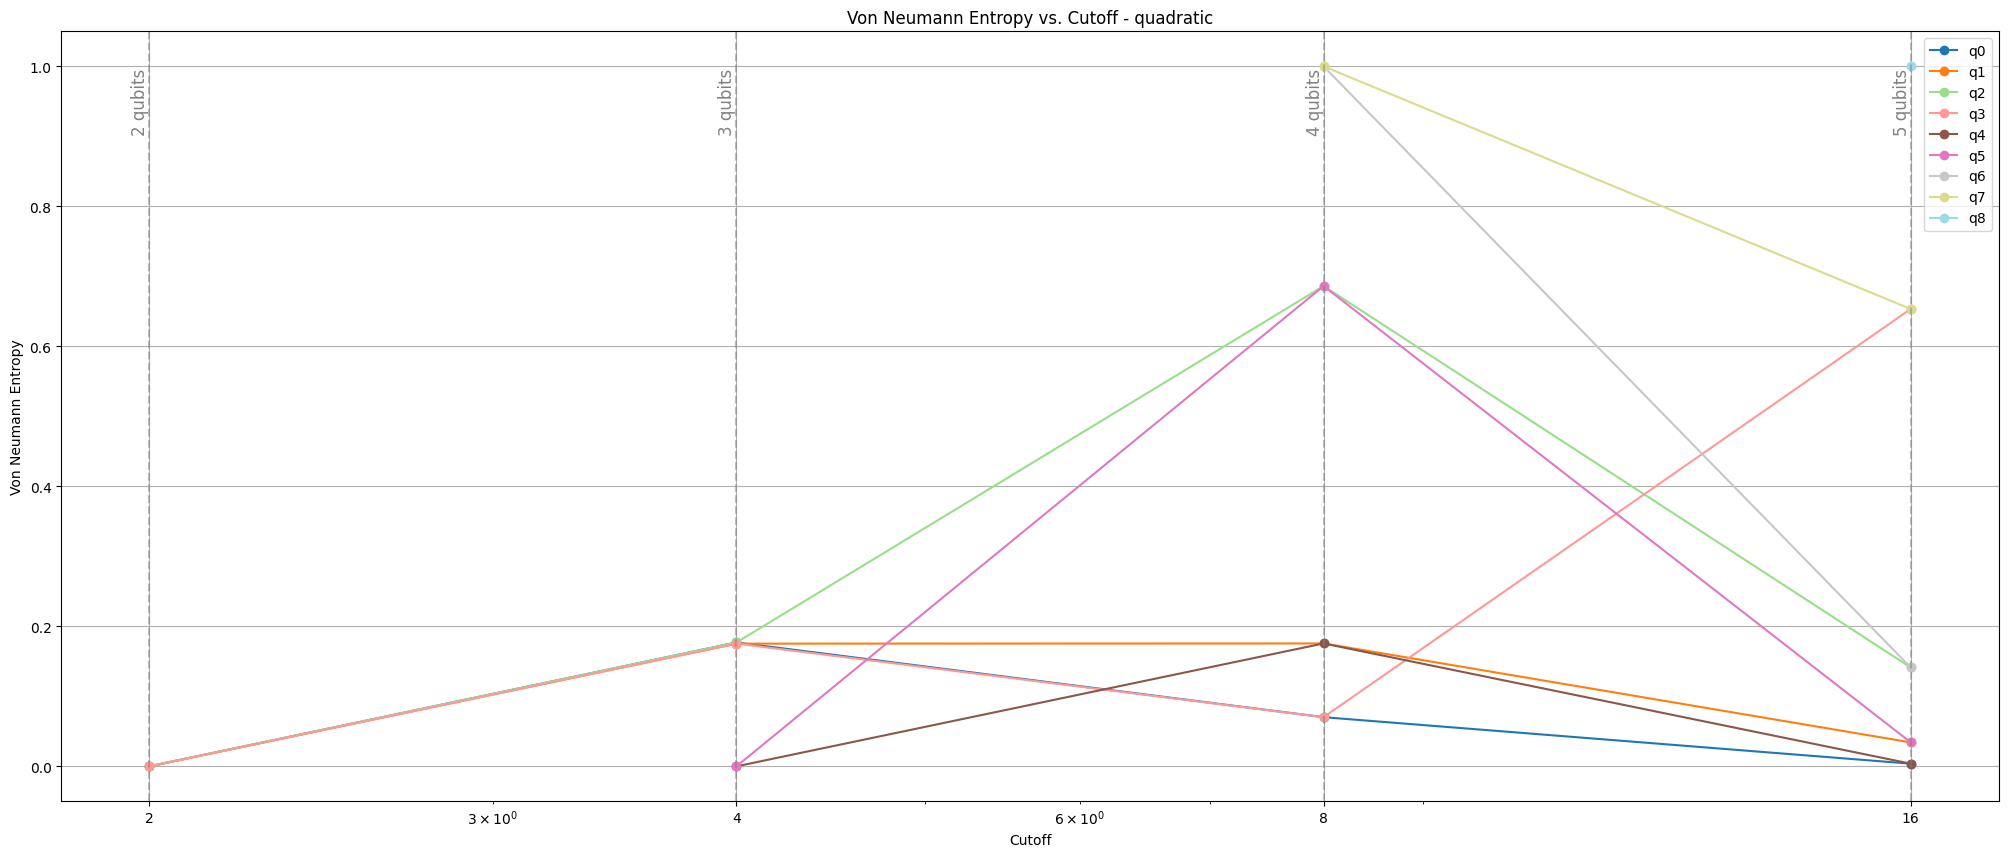

In [84]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
#plt.figure(figsize=(6,4))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key}"# ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Von Neumann Entropy")
plt.title(f"Von Neumann Entropy vs. Cutoff - {potential}")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\VonNeumannPlots\small_plot_{}".format(potential))